# Exective summary of Work Package 2

## Objectives

This work package aims at developing a data-driven fault detection algorithm for the motors in the robot. The algorithm should be able to accurately detect faults under different working conditions of the robot, and to display the results in the GUI developed in WP1.

## Tasks

- Task 1: Training data generation: Generate training data for your model, considering different working conditions of the robot.
- Task 2: Model development.
  - Data cleaning, preprocessing
  - Investigate different possible model and train the final model
- Task 3: GUI design and implementation.
- Task 4: Data challenge: Each group will generate a separate dataset, which will be used to construct a final evaluation dataset for the other groups. The performance of your model will be evaluated through this testing dataset.

## Delierables

- A Jupyter notebook reporting the model development process, including but not limited to:
  - Data cleaning, preprocessing
  - The models you tried and their performance evaluation through cross validation
  - The final model with best performance
- A demo software for condition-monitoring and fault detection:
  - The software should be able to read the data from the robot and display the results in the GUI.
  - The software should be able to detect faults in the robot and display the results in the GUI.
  - Record a video with the robot to demonstrate the functionality of your software.


# Working plan for today's TD

Today, we mainly work on task 2. More specifically, we will work on the following:
1. Explore the data we collected last week, including:
    - Data visualization to explore the patterns of the data
    - Use Principle Component Analysis (PCA) or t-SNE to visualize the data, in order to have a first flavor about the difficulty of the problem 
    - Explore if we have a significant difference between different sequences through visualization and clustering
2. Data cleaning and preprocessing
    - Missing values and outlier handling
    - Feature engineering
3. Apply local outlier analysis model.
4. Apply a simple logistic regression model as a benchmark model for the classification task.

Before starting, please:
- Fetch the most up-to-date version of the github repository.
- Create a new branch called "WP2_TD_Lect_5_YourName", based on the branch "zhiguo_dev" and switch to it.
- Copy the notebook WP2_DATA-DRIVEN FAULT DETECTION/support/WP2_TD_Lect_5 to WP2_DATA-DRIVEN FAULT DETECTION/TD_5/, and rename it to TD_Lect_5_YourName.ipynb
- After finishing this task, push your changes to your github repository.
- Submit a pull request to the "zhiguo_dev" branch.

# Exercise 1 Data exploration

## Task 1: Read the data from the different csv files and store it in a dataframe. 

First, we read all the data from the different sub-folders and store it in a dataframe. In utility.py, there are some supporting functions for this task:
- It reads all the csv file and create a sigle dataframe.
- It rename the features as "data_motor_X+feature names".
- It adds a column "label" to the dataframe, where label = 0 means normal data, while label = 1 means abnormal data.
- It adds a column "seq_idx" to the dataframe, indicating the data are from which sequence. One sequence is generated by one person.

Below, you can find a sample code of reading the data. You need to replace the path with your own path.


```python
from utility import read_data

# Root path to the folder containing the CSV files
path_normal = r'../Data collection_20231109/Normal sequence'
path_failure = r'../Data collection_20231109/Failure sequence'
df = read_data(path_normal, path_failure)
```

**Your task:**

Use the code to create the data frame, and print its column names, and visulize in a data explorer.
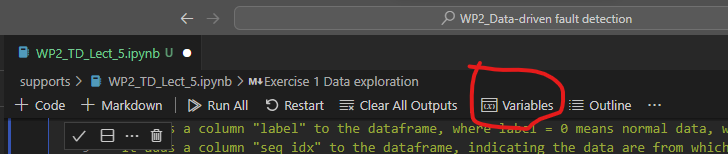

In [543]:
from utility import read_data

# Root path to the folder containing the CSV files
path_normal = r'../Data collection_20231109/Normal sequence'
path_failure = r'../Data collection_20231109/Failure sequence'
df = read_data(path_normal, path_failure)

## Task 2: Data visualization

Going through the different sub-tasks from below. Then, write a summary here about your major observations regarding the patterns in the original data. Below are a few hints for your to organize your summary:
- Do we have a lot noise in the features? Do we need to smooth the data?
- Do we need to scale the features?
- Do we have a lot of outliers? Do we need to remove them?
- Do we have a lot of missing values? Do we need to fill them?
- Do we have a lot of categorical features? Do we need to encode them?

**Submit your summary below:**

### Sub-task 1: Visualize each sequence to explore its basic pattern. 

We would like to visually inspect the time series data. Use the following code to explore the data. 

Note: To use iterative plot, you need to install ipywidgets package: 

```python
pip install ipywidgets

In [544]:
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interactive

# Create dropdown widgets for column selection and sequence_idx selection
column_dropdown = widgets.Dropdown(options=df.columns, description='Select Column:')
sequence_dropdown = widgets.Dropdown(options=df['sequence_idx'].unique(), description='Select sequence_idx:')

# Function to update the plot based on the selected column and sequence_idx
def update_plot(selected_column, selected_sequence_idx):
    filtered_df = df[df['sequence_idx'] == selected_sequence_idx]
    
    plt.figure(figsize=(10, 6))
    plt.plot(filtered_df['time'], filtered_df[selected_column], marker='o')
    plt.xlabel('Time')
    plt.ylabel(selected_column)
    plt.title(f'Plot of {selected_column} for sequence_idx {selected_sequence_idx}')
    x_ticks_labels = [time[-8:] for time in filtered_df['time']]
    plt.xticks(filtered_df['time'][::10], x_ticks_labels[::10], rotation=45, ha='right')  # Display tickers with the last 8 characters    
    plt.grid(True)
    plt.show()

# Create an interactive plot using both dropdown widgets
interactive_plot = interactive(update_plot, selected_column=column_dropdown, selected_sequence_idx=sequence_dropdown)

# Display the interactive plot
interactive_plot


interactive(children=(Dropdown(description='Select Column:', options=('time', 'data_motor_1_position', 'data_m…

### Sub-task 2 Explore the distribution of each feature through histogram and box plot.

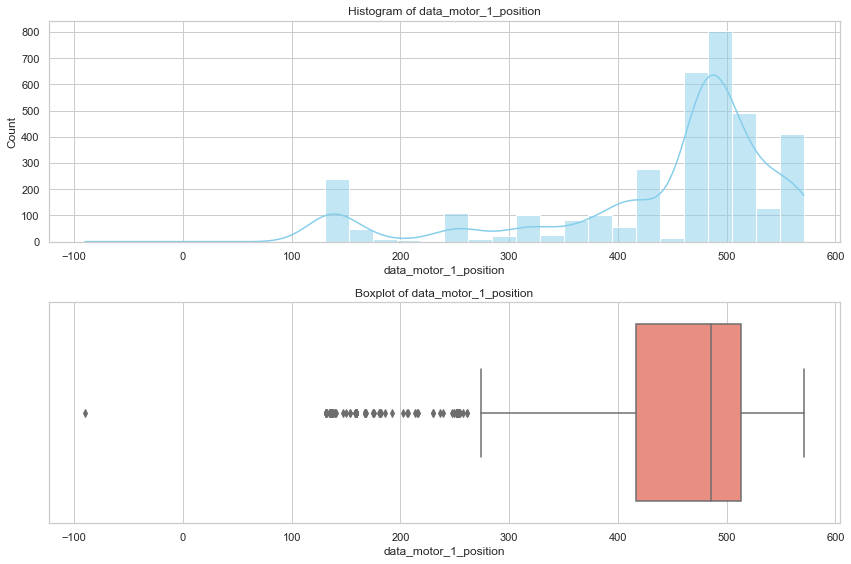

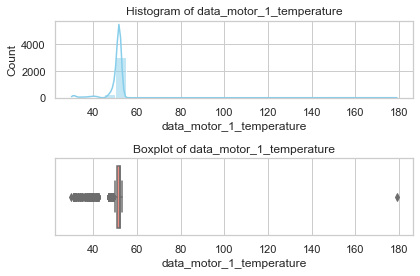

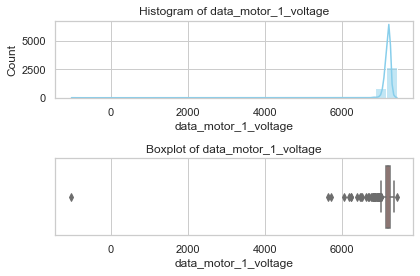

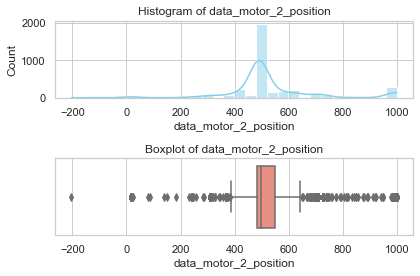

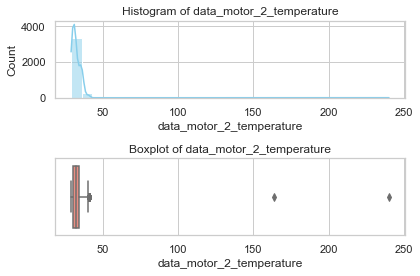

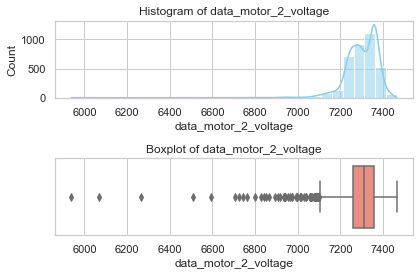

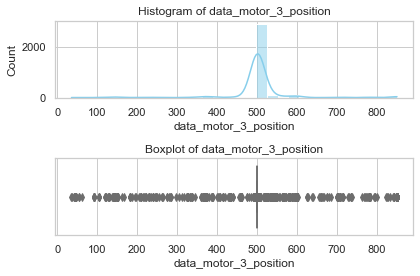

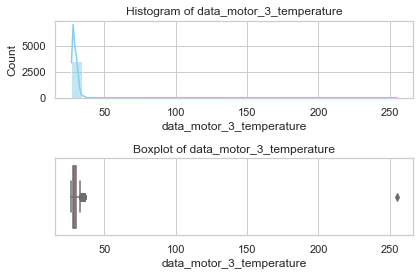

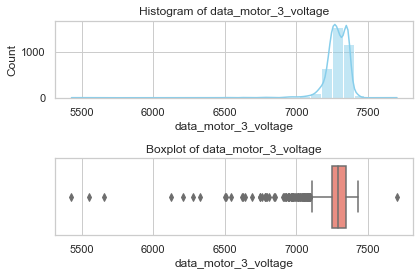

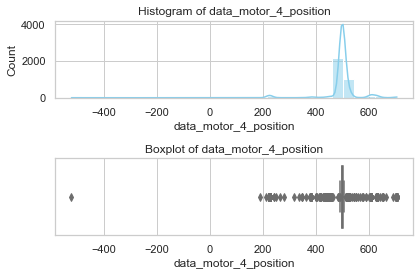

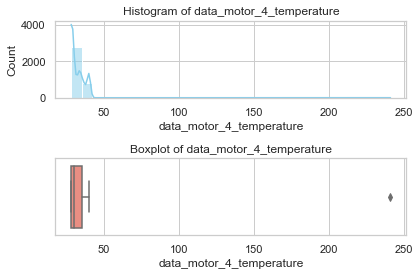

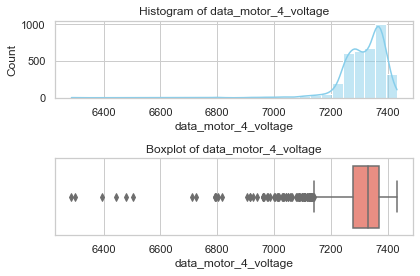

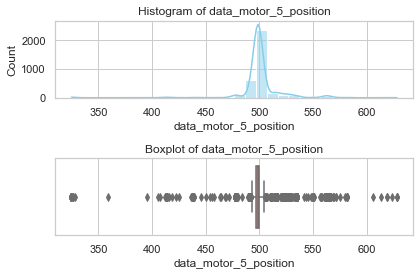

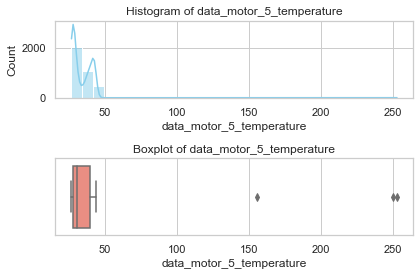

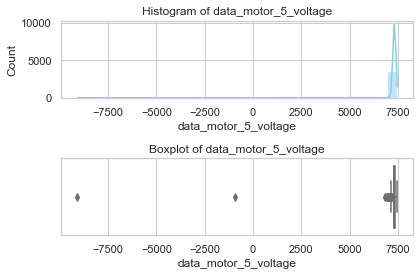

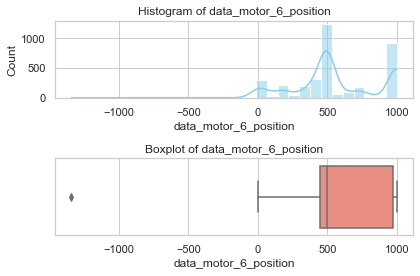

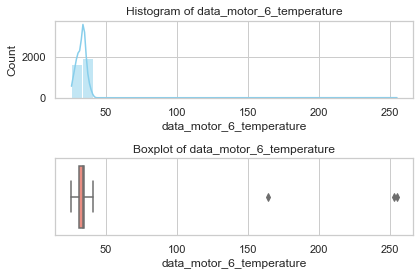

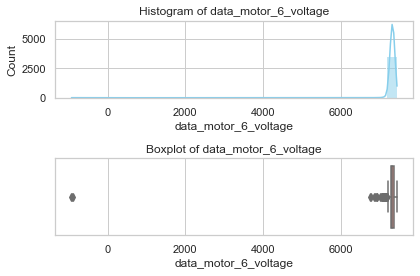

In [545]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# 设置图表的整体大小
plt.figure(figsize=(12, 8))
X = df.drop(['label', 'sequence_idx', 'time'], axis=1)
# 循环遍历每个特征并绘制直方图和箱线图
for column in X.columns:
    plt.subplot(2, 1, 1)  # 上面的图是直方图
    sns.histplot(X[column], kde=True, bins=30, color='skyblue')
    plt.title(f'Histogram of {column}')

    plt.subplot(2, 1, 2)  # 下面的图是箱线图
    sns.boxplot(x=X[column], color='salmon')
    plt.title(f'Boxplot of {column}')

    plt.tight_layout() 
    plt.show()

### Sub-task 3 Use PCA to visulize the data in a 2-d plane.

Normally, before any further analysis, we try to plot all the features directly in a 2-d plane. This is because the 2-d plane is a very simple representation of the data and allows us to visually inspect the patterns of the data. A normal conclusion we can make is whether the data are linear seperable or not, i.e., if you can simply fit a straight line to seperate postitive and negative classes. However, if the data is high-dimensional, it is difficult to visualize it in a 2-d plane. In this case, we can use PCA to reduce the dimensionality of the data and then plot it in a 2-d plane.

Below is a code for performing PCA and plotting the data in a 2-d plane. What can you see from the results?

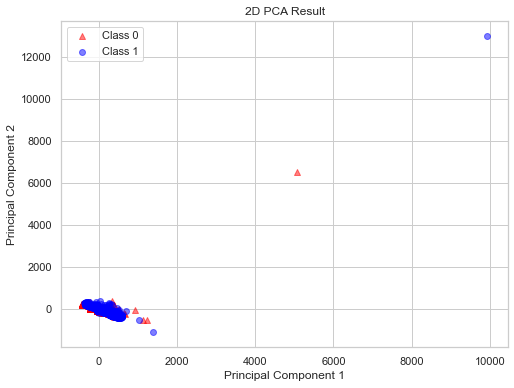

In [546]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Separate the features (X) and the target variable (y)
X = df.drop(['label', 'sequence_idx', 'time'], axis=1)
y = df['label']

# Perform PCA to reduce the dimensionality to 2 dimensions
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Plot the results
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[y == 0, 0], X_pca[y == 0, 1], color='red', marker='^', alpha=.5, label='Class 0')
plt.scatter(X_pca[y == 1, 0], X_pca[y == 1, 1], color='blue', marker='o', alpha=.5, label='Class 1')
plt.title('2D PCA Result')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

In the above analysis, we did not perform data normalization/standardization. Could you try to do that and see if the results change? You can use the follwing code for standardization:

```python
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
```

And this for normalization:

```python
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
```

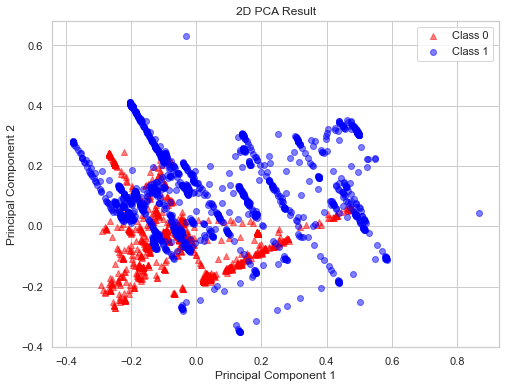

In [547]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler




# Separate the features (X) and the target variable (y)
X = df.drop(['label', 'sequence_idx', 'time'], axis=1)
y = df['label']
scaler = StandardScaler()
X_train = scaler.fit_transform(X)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)

# Perform PCA to reduce the dimensionality to 2 dimensions
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train)

# Plot the results
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[y == 0, 0], X_pca[y == 0, 1], color='red', marker='^', alpha=.5, label='Class 0')
plt.scatter(X_pca[y == 1, 0], X_pca[y == 1, 1], color='blue', marker='o', alpha=.5, label='Class 1')
plt.title('2D PCA Result')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

### Sub-task 4 Investigate if the data from different sequence_idx differ a lot

We can do a data visualization of the PCA, but instead of showing data from class 0 and 1, we can show data from different sequence indexes. This observation is important as if the behavior of different sequence differs a lot, you might improve the performance of your model by developing some sub-models and then aggregate them.

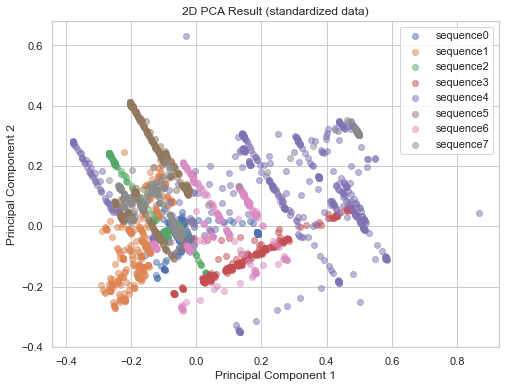

In [548]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X = df.drop(['label', 'sequence_idx','time'], axis=1)
y = df['sequence_idx']

scaler = StandardScaler()
X_train = scaler.fit_transform(X)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)

# Perform PCA to reduce the dimensionality to 2 dimensions
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train)

plt.figure(figsize=(8, 6))
for i in range(8):
    plt.scatter(X_pca[y == i, 0], X_pca[y == i, 1], alpha=.5, label='sequence{id}'.format(id=i))
plt.title('2D PCA Result (standardized data)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

# Exercise 2 Data cleaning and preprocessing

## Task 1: Normalize the dataset.

Define your strategy to normalize the dataset and implement the data. Please pay attention to the difference between fit_transform(), fit(), and transform().

In [549]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split




X = df.drop(['label', 'sequence_idx', 'time'], axis=1)
y = df['label']
# 初始化StandardScaler 归一化
scaler = StandardScaler()

# 对训练数据进行fit和transform
X_train_scaled = scaler.fit_transform(X)
X = pd.DataFrame(X_train_scaled, index=X.index, columns=X.columns)


## Task 2: Define a strategy to remove outliers.

Explain how you remove the outliers and implement your approach here.

In [550]:
import pandas as pd
from scipy import stats

# X = df.drop(['label', 'sequence_idx', 'time'], axis=1)
# Z分数：识别落在一定阈值之外的数据点（例如，Z分数> 3或Z分数<-3）。
# IQR：计算IQR，将在范围[Q1 - 1.5 * IQR，Q3 + 1.5 * IQR]之外的数据点视为异常值。
# Function to remove outliers using Z-score
def remove_outliers_zscore(data_column):
    z_scores = stats.zscore(data_column)
    outliers = (z_scores > 3) | (z_scores < -3)
    return data_column[~outliers]

# Function to remove outliers using IQR
def remove_outliers_iqr(data_column):
    Q1 = data_column.quantile(0.25)
    Q3 = data_column.quantile(0.75)
    IQR = Q3 - Q1
    outliers = (data_column < Q1 - 1.5 * IQR) | (data_column > Q3 + 1.5 * IQR)
    return data_column[~outliers]

# Loop through each column in the DataFrame and remove outliers
for column in X.columns:
    if X[column].dtype in ['int64', 'float64']:
        X[column] = remove_outliers_zscore(X[column])

## Task 3: Define a strategy to smooth the data.

Explain how do you smooth the data and implement your approach here.

In [551]:
# 定义平滑因子
smoothing_factor = 0.2

# Loop through each column in the DataFrame and remove outliers
for column in X.columns:
    if X[column].dtype in ['int64', 'float64']:
        # Remove outliers using the Z-score method
        X[column] = X[column].ewm(alpha=smoothing_factor, adjust=False).mean()
        print(X[column])
    


0      -0.646966
1      -0.646966
2      -0.646966
3      -0.646966
4      -0.646966
          ...   
3590    0.877792
3591    0.877530
3592    0.877320
3593    0.877153
3594    0.878759
Name: data_motor_1_position, Length: 3595, dtype: float64
0            NaN
1            NaN
2            NaN
3            NaN
4            NaN
          ...   
3590    0.342326
3591    0.342329
3592    0.342331
3593    0.386240
3594    0.377460
Name: data_motor_1_temperature, Length: 3595, dtype: float64
0       1.045262
1       1.018202
2       1.023614
3       1.019334
4       0.995000
          ...   
3590    0.231536
3591    0.252832
3592    0.250189
3593    0.248074
3594    0.241463
Name: data_motor_1_voltage, Length: 3595, dtype: float64
0      -0.655073
1      -0.655073
2      -0.655073
3      -0.655073
4      -0.656252
          ...   
3590    1.108052
3591    1.108090
3592    1.108120
3593    1.108145
3594    1.108164
Name: data_motor_2_position, Length: 3595, dtype: float64
0      -0.700841
1

# Exercise 3 Feature engineering

## Task 1: Use violin plot to explore the significance of each feature.

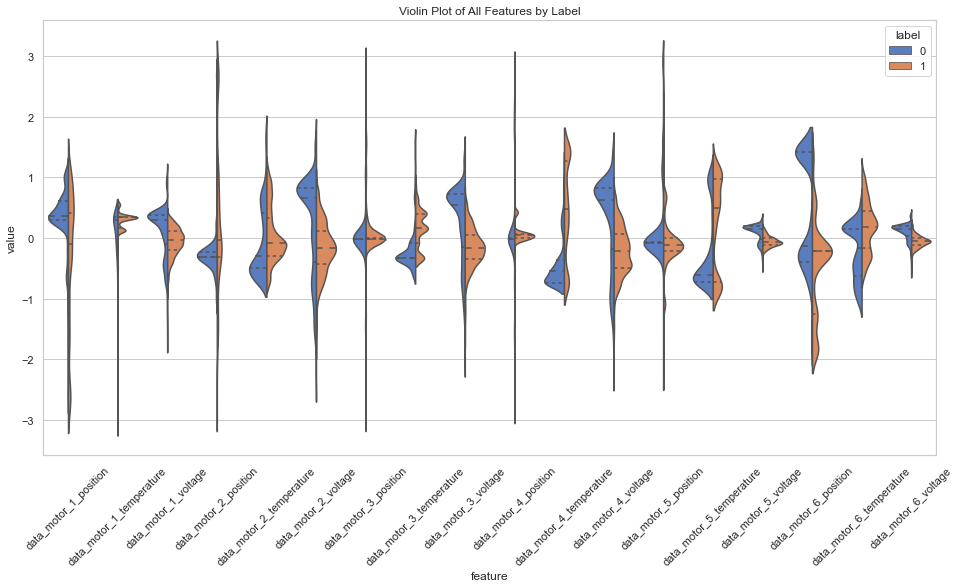

In [552]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing

sns.set(style="whitegrid")


# 将所有特征列合并成一个DataFrame
data_to_plot = pd.concat([y, X], axis=1)

# Melt DataFrame to make it suitable for violin plot
data_melted = pd.melt(data_to_plot, id_vars='label', var_name='feature', value_name='value')

# 绘制小提琴图
plt.figure(figsize=(16, 8))
sns.violinplot(x='feature', y='value', hue='label', data=data_melted, split=True, inner='quart', palette='muted')
plt.title('Violin Plot of All Features by Label')
plt.xticks(rotation=45)  # 可选，用于旋转x轴标签，使其更易读
plt.show()
X = df_number 




We can tell from the violin plot that for the features "data_motor_3_position \ data_motor_5_position "the difference between failures data and normal data is not significant.

## Task 2: Use correlation coefficient matrix to explore the correlation among the features.

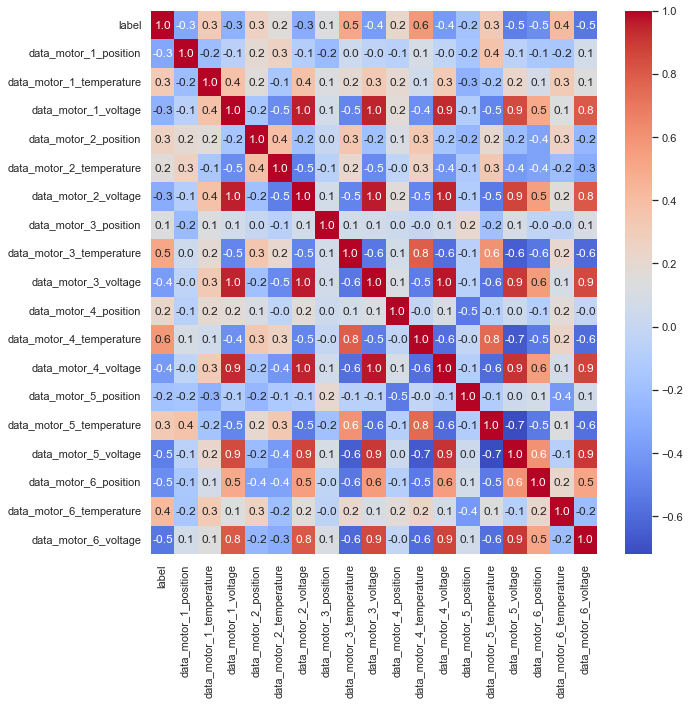

In [553]:

df_cat = pd.concat([y, X], axis=1)

plt.figure(figsize=(10, 10))
sns.heatmap(df_cat.corr(), annot=True, cmap='coolwarm', fmt= '.1f')
plt.show()


the all the temperature and data_monitor_2_position have relative high correlation with label.

## Conclusion of feature engineering

**Write your conclusion of feature engineering here.** For example, which features are most relevant? Which features are not relevant? Which features are redundant? Which features are irrelevant? Eventually, what are your decisions regarding which features to be used?





we can tell from the violin plot and the  correlation coefficient matrix we know that the data_monitor_2_position\data_motor_1_temperature\data_motor_2_temperature\data_motor_3_temperature\data_motor_4_temperature\data_motor_5_temperature\data_motor_6_temperature these labels are most relavant. and data_motor_3_position \ data_motor_5_position is reduntant.



# Exercise 4 Implement the statistical testing approach for fault detection

In this exercise, we interpret the statistical testing approach for fault detection. The basic idea of statistical testing approach is that we fit a multi-dimensitional distribution to the observation data under normal working condition. Then, when a new data point arrives, we design a hypothesis test to see whether the new data point is consistent with the distribution. If the new data point is consistent with the distribution, we can conclude that the fault is not due to the faulty component.

The benefit of this approach is that, to design the detection algrothim, we do not need failed data. Also, the computational time is short as all we need is just to compute the pdf and compare it to a threshold.

In this exercise, you need to:
- Seperate the original dataset into training and testing datasets.
- Fit a multi-dimensitional distribution to the training dataset.
- Design a fault detection algorithm based on the fitted distribution.

The following block defines a few functions that you can use.

In [554]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import multivariate_normal


def estimateGaussian(X):
    '''Given X, this function estimates the parameter of a multivariate Gaussian distribution.'''
    mu = np.mean(X, axis=0)
    sigma2 = np.var(X, axis=0)
    return mu, sigma2


def classify(X, distribution, log_epsilon=-50):
    '''Given X, this function classifies each sample in X based on the multivariate Gaussian distribution. 
       The decision rule is: if the log pdf is less than log_epsilon, we predict 1, as the sample is unlikely to be from the distribution, which represents normal operation.
    '''
    p = distribution.logpdf(X)
    predictions = (p < log_epsilon).astype(int)
    
    return predictions

Please design your algorithm below:

In [555]:
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
from scipy.stats import multivariate_normal
from sklearn.metrics import accuracy_score

# X = X[['data_motor_2_position','data_motor_1_temperature','data_motor_2_temperature',
#               'data_motor_3_temperature','data_motor_4_temperature','data_motor_5_temperature','data_motor_6_temperature']]
# X = X.drop(['data_motor_3_position','data_motor_3_voltage'], axis=1)
# X = X.drop(['data_motor_3_position','data_motor_5_position'], axis=1)
X = X.drop(['data_motor_3_position'], axis=1)



# Step 1: Separate the original dataset into training and testing datasets
x_train, x_test,y_train, y_test = train_test_split(X, y,test_size=0.1, random_state=42)

x_train_normal = x_train[y_train == 0]
mu, sigma2 = estimateGaussian(x_train_normal)

In [556]:
# Fit the distribution.
# Put your code here.

# Construct a multivariate Gaussian distribution to represent normal operation.
distribution = multivariate_normal(mean=mu, cov=np.diag(sigma2))

# Try to predict the labels of the test set X_test.
# Put your code here.
y_pred = classify(x_test, distribution, log_epsilon=-19.5)

# Calculate accuracy of the prediction.
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8472222222222222


**Discussions:**
- Can you please try to improve the performance of this approach?
    - For example, by normalizating the data?
    - By smoothing the data?
    - By reducing feature number?
    - etc.
- The parameter log_epsilon defines the threshold we use for making classification. What happens if you change it?
- Could you discuss how we should get the best value for this parameter?